# Video DataLoader with DALI readers.video

### Goal
This demo will go over creation of a pipeline using the [readers.video](../../../operations/nvidia.dali.fn.readers.video.html) operator.
The pipeline will return a batch of frame sequences. These sequences are an arbitrary number of frames (images). Sequences are of the format `(F, H, W, C)` where `F` is the number of frames and `C`,`H`, `W` are image dimensions.

In [1]:
import os
import numpy as np

from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types

The `count` parameter will define how many frames we want in each sequence sample.

In [2]:
batch_size = 2
sequence_length = 8 # number of frames 
initial_prefetch_size = 16
video_directory = os.path.join(
    os.environ["DALI_EXTRA_PATH"], "db", "video", "sintel", "video_files"
)
video_files = [video_directory + "/" + f for f in os.listdir(video_directory)]
n_iter = 6

**Note**: `DALI_EXTRA_PATH` environment variable should point to the place where data from [DALI extra repository](https://github.com/NVIDIA/DALI_extra) is downloaded. Please make sure that the proper release tag is checked out. 

## Running the Pipeline

We can then define a minimal pipeline that will output directly the [readers.video](../../../operations/nvidia.dali.fn.readers.video.html) outputs:

In [3]:
@pipeline_def
def video_pipe(filenames):
    videos = fn.readers.video(
        device="gpu",
        filenames=filenames,
        sequence_length=sequence_length,
        shard_id=0,
        num_shards=1,
        random_shuffle=True,
        initial_fill=initial_prefetch_size,
    )
    return videos

Caution: One important thing to note here is tuning `initial_fill`, which corresponds to the reader prefetch buffer initial size. Since this buffer will be filled of `initial_fill` sequences, the total number of frames can be really huge! So set it consequently to not OOM during training.

Let's try to build and run a `video_pipe` on device 0 that will output `batch_size` sequences of `count` frames at each iteration.


In [9]:
pipe = video_pipe(
    batch_size=batch_size, num_threads=2, device_id=0, filenames=video_files, seed=123456
)
pipe.build()
for i in range(n_iter):
    pipe_out = pipe.run()
    sequences_out = pipe_out[0].as_cpu().as_array()
    print(sequences_out.shape)

(2, 8, 720, 1280, 3)
(2, 8, 720, 1280, 3)
(2, 8, 720, 1280, 3)
(2, 8, 720, 1280, 3)
(2, 8, 720, 1280, 3)
(2, 8, 720, 1280, 3)


### Results

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

In [11]:
def show_sequence(sequence):
    columns = 4
    rows = (sequence_length + 1) // (columns)
    fig = plt.figure(figsize=(32, (16 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows * columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(sequence[j])

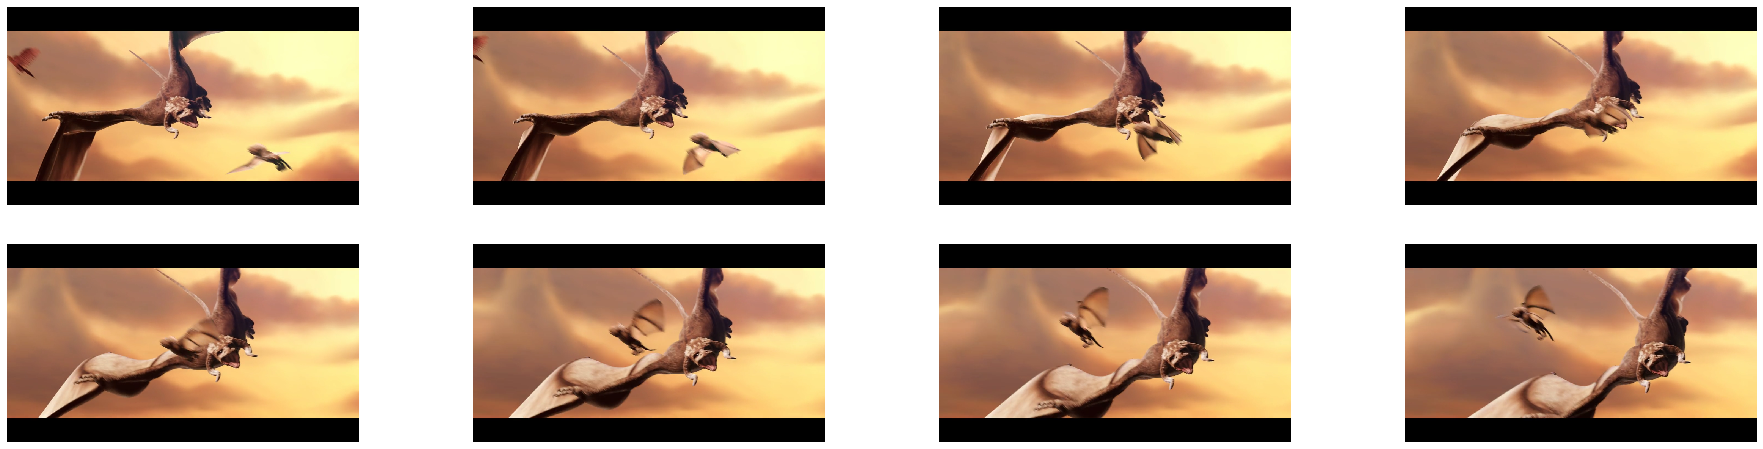

In [12]:
pipe_out = pipe.run()
sequences_out = pipe_out[0].as_cpu().as_array()
show_sequence(sequences_out[0])